In [5]:
# Imports
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate


In [7]:
# Load Datasets
books = pd.read_csv('Dataset/books.csv')
ratings = pd.read_csv('Dataset/ratings.csv')
tags = pd.read_csv('Dataset/tags.csv')
book_tags = pd.read_csv('Dataset/book_tags.csv')

In [8]:
# Checking the shapes of the datasets
print("The books dataset has:", books.shape[0], "entries.")
print("The ratings dataset has:", ratings.shape[0], "entries.")
print("The tags dataset has:", tags.shape[0], "entries.")
print("The book_tags dataset has:", book_tags.shape[0], "entries.")

The books dataset has: 10000 entries.
The ratings dataset has: 5976479 entries.
The tags dataset has: 34252 entries.
The book_tags dataset has: 999912 entries.


In [9]:
# Check for missing Values
print("Is there NaN values? \n On books dataset:",  books.isnull().values.any(), 
      "\n On ratings dataset:", ratings.isnull().values.any(),
     "\n On tags dataset:", tags.isnull().values.any(),
     "\n On book_tags dataset:", book_tags.isnull().values.any())

Is there NaN values? 
 On books dataset: True 
 On ratings dataset: False 
 On tags dataset: False 
 On book_tags dataset: False


In [10]:
null_counts = books.isnull().sum()
null_counts[null_counts>0]

isbn                          700
isbn13                        585
original_publication_year      21
original_title                585
language_code                1084
dtype: int64

In [11]:
# Delete NaN values of original_publication_year
for x in ["original_publication_year"]:
    books = books[books[x].notnull()]

# Delete negative values
books = books[(books['original_publication_year'] >= 0)]
print("Now we have", books.shape[0], "entrances.")

Now we have 9948 entrances.


In [12]:
# Print the head of the books dataset.
pd.set_option('display.max_columns', None)
books.head(3)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...


In [13]:
# Drop the columns that we don't need.
books.drop(['best_book_id','work_id','work_ratings_count','ratings_1', 'ratings_2','ratings_3','ratings_4','ratings_5','image_url','small_image_url','isbn','isbn13'], axis=1,inplace=True)

In [14]:
# Print head of the ratings dataset
ratings.head(3)

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5


In [15]:
print("The ratings can be:", ratings.rating.unique())

The ratings can be: [5 4 3 2 1]


In [16]:
# Grouping by the book_id to know how many ratings have each book
rating_book = ratings.groupby('book_id').book_id.apply(lambda x: len(x)).sort_values()
print("The minimum number of ratings per book is:", rating_book.min())
print("The maximum number of ratings per book is:", rating_book.max())

The minimum number of ratings per book is: 8
The maximum number of ratings per book is: 22806


In [17]:
rating_user = ratings.groupby('user_id').user_id.apply(lambda x: len(x)).sort_values()
print("The minimum number of ratings per user is:", rating_user.min())
print("The maximum number of ratings per user is:", rating_user.max())

The minimum number of ratings per user is: 19
The maximum number of ratings per user is: 200


In [18]:
book_tags.head(3)

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173


In [19]:
tags.sample(3)

,tag_id,tag_name
15712,15712,internment
7798,7798,comics-etc
8223,8223,cooking-by-it-s-recipes


In [20]:
# Merge the two datasets grouping by the tag_id. 
data = pd.merge(book_tags, tags, left_on='tag_id', right_on='tag_id', how='inner')

titles = books[['book_id','title','goodreads_book_id','authors']]

# Merge the book dataset with the new one to know the title and the author
data = pd.merge(titles, data, left_on='goodreads_book_id', right_on='goodreads_book_id')
data.head(3)

,book_id,title,goodreads_book_id,authors,tag_id,count,tag_name
0,1,"The Hunger Games (The Hunger Games, #1)",2767052,Suzanne Collins,30574,11314,to-read
1,1,"The Hunger Games (The Hunger Games, #1)",2767052,Suzanne Collins,11305,10836,fantasy
2,1,"The Hunger Games (The Hunger Games, #1)",2767052,Suzanne Collins,11557,50755,favorites


In [21]:
books[['book_id','original_publication_year','average_rating','ratings_count']].describe()

,book_id,original_publication_year,average_rating,ratings_count
count,9948.000000,9948.000000,9948.000000,9.948000e+03
mean,5001.972758,1989.688983,4.002050,5.400569e+04
std,2886.580085,63.459165,0.254411,1.576062e+05
min,1.000000,8.000000,2.470000,2.716000e+03
25%,2502.750000,1990.000000,3.850000,1.356975e+04
50%,5006.500000,2004.000000,4.020000,2.115850e+04
75%,7502.250000,2011.000000,4.180000,4.105350e+04
max,10000.000000,2017.000000,4.820000,4.780653e+06


In [22]:
books[books['original_publication_year'] == 8]

,book_id,goodreads_book_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_text_reviews_count
2365,2366,1715,437,"Ovid, David Raeburn, Denis Feeney",8.0,Metamorphoses,Metamorphoses,eng,4.03,42590,1121


C:\Users\AMIRA\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


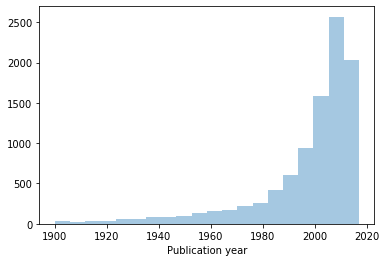

In [23]:
# Function that plots the distribution of the books by the year.
def plot_yearDistribution():
    # Filter booms written from 1900
    years_filter = books[(books['original_publication_year'] >= 1900)]
    
    #Plot the distribution of the books by the publication year.
    sns.distplot(years_filter['original_publication_year'], kde=False, bins=20)
    plt.xlabel("Publication year")
    plt.show()

plot_yearDistribution()

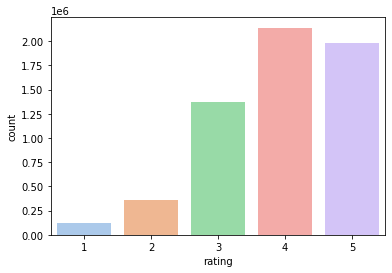

In [24]:
sns.countplot(data=ratings, x ='rating', palette='pastel')
plt.show()

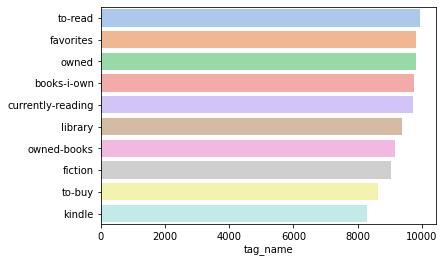

In [25]:
# Count number of times each tag appears and sort them.
top_tags = data['tag_name'].value_counts(ascending = False).head(10)

sns.barplot(x = top_tags, y=top_tags.index, palette='pastel')
plt.show()

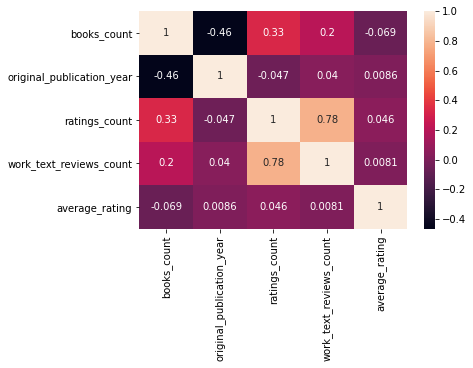

In [26]:
corr = books[['books_count','original_publication_year','ratings_count','work_text_reviews_count','average_rating']].corr()
sns.heatmap(corr,annot=True)
plt.show()

In [27]:
pd.set_option('display.max_colwidth', -1)
books[['title','ratings_count']].sort_values(by=['ratings_count'], ascending=False).head(5)

<ipython-input-27-ad1062953104>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,title,ratings_count
0,"The Hunger Games (The Hunger Games, #1)",4780653
1,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",4602479
2,"Twilight (Twilight, #1)",3866839
3,To Kill a Mockingbird,3198671
4,The Great Gatsby,2683664


In [28]:
books[['title','average_rating']].sort_values(by=['average_rating'], ascending=False).head(5)

,title,average_rating
3627,The Complete Calvin and Hobbes,4.82
3274,"Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)",4.77
861,"Words of Radiance (The Stormlight Archive, #2)",4.77
8853,Mark of the Lion Trilogy,4.76
7946,ESV Study Bible,4.76


In [29]:
# For each book, join all their tags
list_tags = data.groupby(by='goodreads_book_id')['tag_name'].apply(set).apply(list)

# Append this list of tags on the books dataset
books['tags'] = books['goodreads_book_id'].apply(lambda x: ' '.join(list_tags[x]))

In [30]:
pd.reset_option('max_colwidth')
books.head(3)

,book_id,goodreads_book_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_text_reviews_count,tags
0,1,2767052,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,155254,english to-read read-in-2011 scifi action fant...
1,2,3,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,75867,english to-read urban-fantasy england harry-po...
2,3,41865,226,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,95009,english to-read urban-fantasy supernatural ame...


In [31]:
# Function to get the index of the book given its title. 
def get_book_id(book_title):
    index = books.index[books['original_title'] == book_title].to_list()
    if index:
        return index[0]
    else:
        return None

# Function to get the title of a book given its id.
def get_book_title(book_id):
    title = books.iloc[book_id]['original_title']
    return title

# Function that takes the book title and returns the most similar books.
def get_similar_books(title, n=5):
    
    # Get the book id
    book_id = get_book_id(title)
    
    if book_id is None:
        print("Book not found.")
    else:
        
        # Get the pariwsie similarity scores of all books with that book
        book_similarities = list(enumerate(similarities[book_id]))
        
        # Sort the books based on the similarity scores
        book_similarities = sorted(book_similarities, key=lambda x: x[1], reverse=True)
        
        # Get the scores of the 5 most similar book
        most_similar_books = book_similarities[1:1+n]
        most_similar_books = list(map(lambda x: (get_book_title(x[0]), round(x[1], 2)), most_similar_books))
        
        most_similar_books_df = pd.DataFrame(most_similar_books, columns=['Title', 'Similarity'])
        print("For this book we will recommand you:\n")
        
        return most_similar_books_df.style.hide_index()

In [32]:
tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf.fit_transform(books['tags'])

In [33]:
similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [34]:
get_similar_books("The Hunger Games")


For this book we will recommand you:



Title,Similarity
Catching Fire,0.960000
Mockingjay,0.940000
The Hunger Games Box Set,0.900000
Divergent,0.740000
Delirium,0.670000


In [35]:
# We keep only the books from the year 2000.
newer_books = books[books['original_publication_year'] > 2000]

df_books = newer_books[['book_id','original_title', 'title']]

# We are left with the ratings that have been made to the books from the year 2000.
df_ratings = ratings[ratings.book_id.isin(df_books.book_id)]

In [36]:
# Count the users that has voted more than 100 times. 
user_counts = df_ratings['user_id'].value_counts()
df_ratings = df_ratings[df_ratings['user_id'].isin(user_counts[user_counts >= 100].index)]

In [37]:
df_titles = df_books[['book_id','title']]
df_titles.set_index('book_id', inplace = True)

In [38]:
# Function that takes the user id and returns the most similar books. 
def recommend_books(user_id):
    
    # Getting all the ratings that has done the user
    user = df_ratings[df_ratings['user_id'] == user_id]
    user = user.join(df_titles)['title']
    
    user = df_titles.copy()
    user = user.reset_index()
    
    # We get the books that the user has not yet read. 
    user = user[~user['book_id'].isin(df_books)]
    
    # We check the predicted score using the predict function and getting the estimation.
    user['estimate_score'] = user['book_id'].apply(lambda x: svd.predict(user_id, x).est)
    
    # Sort the books by the estimate score that the predict returns.
    user = user.drop('book_id', axis=1)
    user = user.sort_values('estimate_score', ascending=False)
    
    return user.head(5)

In [39]:
reader = Reader()

data = Dataset.load_from_df(df_ratings[['user_id','book_id','rating']], reader)
svd = SVD()

# cross-validation with no. of kfold=5 (can be changed per your need)
cross_validate(svd, data, measures=['rmse', 'mae'], cv=5,verbose=False)

{'test_rmse': array([0.81533645, 0.81121295, 0.81170851, 0.81162049, 0.81221035]),
 'test_mae': array([0.63095314, 0.62866419, 0.62897453, 0.62859031, 0.62954645]),
 'fit_time': (35.942341804504395,
  34.81632375717163,
  34.86176085472107,
  32.37972664833069,
  33.80677032470703),
 'test_time': (1.7455005645751953,
  1.2338147163391113,
  1.22444748878479,
  1.1895828247070312,
  1.314497470855713)}

In [40]:

data_train = data.build_full_trainset()
svd.fit(data_train)

In [41]:
user_id = 16601
recommend_books(user_id)

,title,estimate_score
24,"Eclipse (Twilight, #3)",4.083444
399,"Words of Radiance (The Stormlight Archive, #2)",4.042970
26,"Breaking Dawn (Twilight, #4)",4.026416
142,"City of Fallen Angels (The Mortal Instruments,...",4.023615
811,Being Mortal: Medicine and What Matters in the...,3.902423
